# **Premier League Predictions**

# **Contents**:
    1. Introduction
    2. Pre-model Exploration
        2.1 Validity Of Poisson Approximation
    3. Target Vector Construction
        3.1 Framing of Challenge
        3.2 Derivation
    4. Feature Construction
        4.1 Feature Explanation
        4.2 Creating Rolling Features
        4.3 Enriching Features
    5. Initial ML Model
        5.1 Preparing data

In [1]:
from AssistingFunctions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import poisson, skellam
from scipy.optimize import root_scalar, minimize_scalar

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# **1. Introduction**

# **2. Pre-model Exploration**

## **2.1 Validity Of Poisson Approximation**

### **2.1.1 Initial Theory**

I believe the likelihood of a certain number of goals being scored by each team can be reasonably modelled using a Poisson distribution. This is because a football match satisfies many of the key assumptions required for a Poisson process: goals are discrete events, they occur relatively rarely over a fixed time interval, and they can be modelled using an underlying average scoring rate. While these assumptions are not perfectly met in practice, they are sufficiently close to justify a Poisson-based approximation.

To investigate this, I compare goal-count probabilities predicted by a Poisson model with probabilities implied by betting odds for a selection of matches. In doing so, I assume betting markets are efficient, meaning that when odds imply a certain probability (e.g. odds of 2.0 implying a 50% chance), this probability is close to the true likelihood of the event occurring.

### **2.1.2 General Functions**

In [1]:
# Optimisation of Poisson functions
def poisson_goals(lam, goals, probs):
    preds = poisson.pmf(goals, lam)
    rmse = np.sqrt(np.mean((probs - preds) ** 2))
    return rmse

def optimised_poisson(goals, probs):
    lam_list = np.linspace(0, 5, 501)
    optimal_lam = 0
    best_rmse = np.inf
    for lam in lam_list:
        rmse = poisson_goals(lam, goals, probs)
        if rmse < best_rmse:
            best_rmse = rmse
            optimal_lam = lam
    preds = poisson.pmf(goals, optimal_lam)
    return preds

### **2.1.3 Real Data Comparisons**

**Game 1: Manchester United vs. Sunderland**

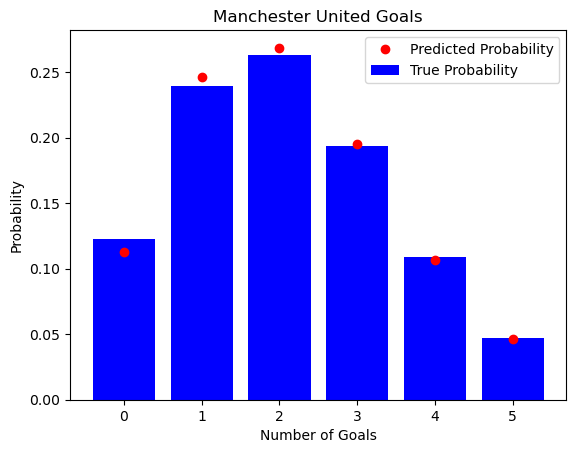

The maximum probability delta is 0.69 %


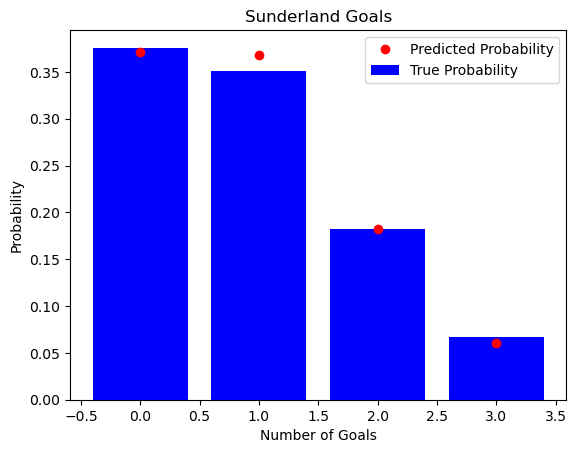

The maximum probability delta is 1.68 %


In [3]:
# Initialise Manchester United 
m_implied_prob_0 = 1/17.02 + 1/19.53 + 1/34.74 + 1/82.43
m_implied_prob_1 = 1/8.4 + 1/9.73 + 1/19.57 + 1/47.56
m_implied_prob_2 = 1/7.9 + 1/8.48 + 1/17.48 + 1/47.36
m_implied_prob_3 = 1/11.52 + 1/11.28 + 1/21.86 + 1/59.77
m_implied_prob_4 = 1/20.89 + 1/20.81 + 1/36.82 + 1/91.02
m_implied_prob_5 = 1/45.05 + 1/44.88 + 1/76.36

# Removing vig
total_implied_prob = m_implied_prob_0 + m_implied_prob_1 + m_implied_prob_2 + m_implied_prob_3 + m_implied_prob_4 + m_implied_prob_5 + 0.03
m_prob_0 = m_implied_prob_0 / total_implied_prob
m_prob_1 = m_implied_prob_1 / total_implied_prob
m_prob_2 = m_implied_prob_2 / total_implied_prob
m_prob_3 = m_implied_prob_3 / total_implied_prob
m_prob_4 = m_implied_prob_4 / total_implied_prob
m_prob_5 = m_implied_prob_5 / total_implied_prob


# Initialise Sunderland 
s_implied_prob_0 = (1/17.02) + (1/8.40) + (1/7.90) + (1/11.52) + (1/20.89) + (1/45.05)
s_implied_prob_1 = (1/19.53) + (1/9.73) + (1/8.48) + (1/11.28) + (1/20.81) + (1/44.88)
s_implied_prob_2 = (1/34.74) + (1/19.57) + (1/17.48) + (1/21.86) + (1/36.82) + (1/76.36)
s_implied_prob_3 = (1/82.43) + (1/47.56) + (1/47.36) + (1/59.77) + (1/91.02)

# Removing vig
s_total_implied = s_implied_prob_0 + s_implied_prob_1 + s_implied_prob_2 + s_implied_prob_3 + 0.03
s_prob_0 = s_implied_prob_0 / s_total_implied
s_prob_1 = s_implied_prob_1 / s_total_implied
s_prob_2 = s_implied_prob_2 / s_total_implied
s_prob_3 = s_implied_prob_3 / s_total_implied

# Plots
m_goals = [0, 1, 2, 3, 4, 5]
s_goals = [0, 1, 2, 3]
m_probs = [m_prob_0, m_prob_1, m_prob_2, m_prob_3, m_prob_4, m_prob_5]
s_probs = [s_prob_0, s_prob_1, s_prob_2, s_prob_3]

# Predictions
m_preds = optimised_poisson(m_goals, m_probs)
s_preds = optimised_poisson(s_goals, s_probs)
m_delta = 100*np.max(m_preds - m_probs)
s_delta = 100*np.max(s_preds - s_probs)

# Plots
plt.bar(m_goals, m_probs, color='b', label='True Probability')
plt.plot(m_goals, m_preds, color='r', label='Predicted Probability', linestyle="None", marker="o")
plt.title("Manchester United Goals")
plt.xlabel("Number of Goals")
plt.ylabel("Probability")
plt.legend()
plt.show()
print(f"The maximum probability delta is {m_delta:.2f} %")

plt.bar(s_goals, s_probs, color='b', label='True Probability')
plt.plot(s_goals, s_preds, color='r', label='Predicted Probability', linestyle="None", marker="o")
plt.title("Sunderland Goals")
plt.xlabel("Number of Goals")
plt.ylabel("Probability")
plt.legend()
plt.show()
print(f"The maximum probability delta is {s_delta:.2f} %")

**Game 2: Arsenal vs. West Ham**

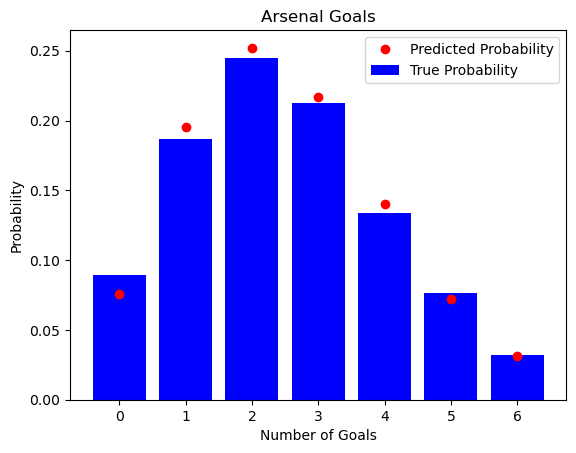

The maximum probability delta is 0.86 %


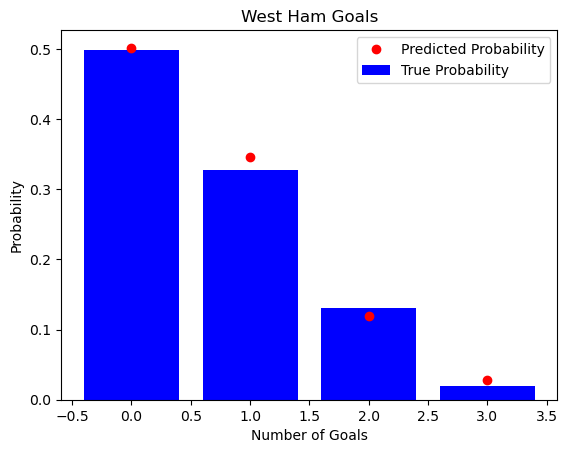

The maximum probability delta is 1.87 %


In [4]:
# Initialise Arsenal 
a_implied_prob_0 = (1/17.500) + (1/26.270) + (1/61.600)
a_implied_prob_1 = (1/8.320) + (1/12.350) + (1/30.740)
a_implied_prob_2 = (1/6.750) + (1/9.950) + (1/21.730) + (1/85.910)
a_implied_prob_3 = (1/7.020) + (1/12.690) + (1/31.580) + (1/78.660)
a_implied_prob_4 = (1/11.730) + (1/16.640) + (1/45.330)
a_implied_prob_5 = (1/21.230) + (1/29.530) + (1/68.080)
a_implied_prob_6 = (1/43.120) + (1/58.520)

# Removing vig
a_total_implied_prob = (a_implied_prob_0 + a_implied_prob_1 + a_implied_prob_2 + a_implied_prob_3 + a_implied_prob_4 + a_implied_prob_5 + 
                        a_implied_prob_6 + 0.03)

a_prob_0 = a_implied_prob_0 / a_total_implied_prob
a_prob_1 = a_implied_prob_1 / a_total_implied_prob
a_prob_2 = a_implied_prob_2 / a_total_implied_prob
a_prob_3 = a_implied_prob_3 / a_total_implied_prob
a_prob_4 = a_implied_prob_4 / a_total_implied_prob
a_prob_5 = a_implied_prob_5 / a_total_implied_prob
a_prob_6 = a_implied_prob_6 / a_total_implied_prob


# Initialise West Ham 
w_implied_prob_0 = (1/17.500) + (1/8.320) + (1/6.750) + (1/7.020) + (1/11.730) + (1/21.230) + (1/43.120)
w_implied_prob_1 = (1/26.270) + (1/12.350) + (1/9.950) + (1/12.690) + (1/16.640) + (1/29.530) + (1/58.520)
w_implied_prob_2 = (1/61.600) + (1/30.740) + (1/21.730) + (1/31.580) + (1/45.330) + (1/68.080)
w_implied_prob_3 = (1/85.910) + (1/78.660)

# Removing vig
w_total_implied_prob = w_implied_prob_0 + w_implied_prob_1 + w_implied_prob_2 + w_implied_prob_3 + 0.03
w_prob_0 = w_implied_prob_0 / w_total_implied_prob
w_prob_1 = w_implied_prob_1 / w_total_implied_prob
w_prob_2 = w_implied_prob_2 / w_total_implied_prob
w_prob_3 = w_implied_prob_3 / w_total_implied_prob


# Plots
a_goals = [0, 1, 2, 3, 4, 5, 6]
w_goals = [0, 1, 2, 3]
a_probs = [a_prob_0, a_prob_1, a_prob_2, a_prob_3, a_prob_4, a_prob_5, a_prob_6]
w_probs = [w_prob_0, w_prob_1, w_prob_2, w_prob_3]

# Predictions
a_preds = optimised_poisson(a_goals, a_probs)
w_preds = optimised_poisson(w_goals, w_probs)
a_delta = 100*np.max(a_preds - a_probs)
w_delta = 100*np.max(w_preds - w_probs)

# Plots
plt.bar(a_goals, a_probs, color='b', label='True Probability')
plt.plot(a_goals, a_preds, color='r', label='Predicted Probability', linestyle="None", marker="o")
plt.title("Arsenal Goals")
plt.xlabel("Number of Goals")
plt.ylabel("Probability")
plt.legend()
plt.show()
print(f"The maximum probability delta is {a_delta:.2f} %")

plt.bar(w_goals, w_probs, color='b', label='True Probability')
plt.plot(w_goals, w_preds, color='r', label='Predicted Probability', linestyle="None", marker="o")
plt.title("West Ham Goals")
plt.xlabel("Number of Goals")
plt.ylabel("Probability")
plt.legend()
plt.show()
print(f"The maximum probability delta is {w_delta:.2f} %")

**Game 3: Chelsea vs. Liverpool**

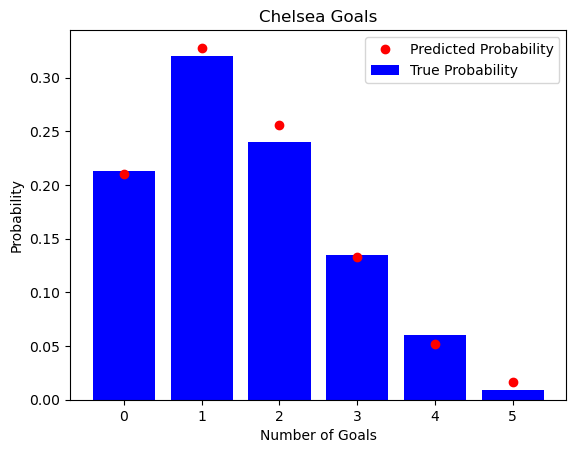

The maximum probability delta is 1.61 %


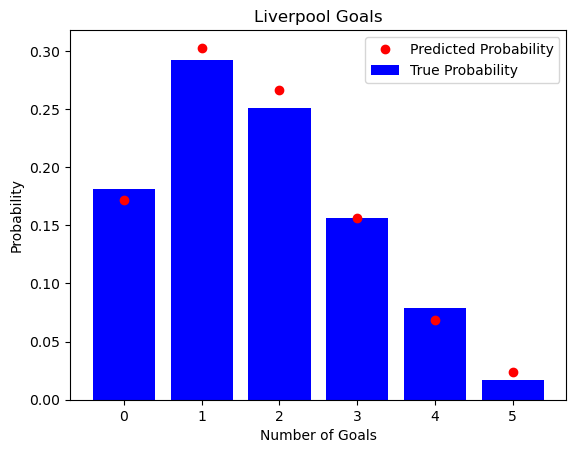

The maximum probability delta is 1.56 %


In [5]:
# Initialise Chelsea 
c_implied_prob_0 = (1/16.820) + (1/12.000) + (1/14.630) + (1/26.060) + (1/55.750)
c_implied_prob_1 = (1/16.120) + (1/7.760) + (1/9.130) + (1/15.970) + (1/35.470) + (1/88.730)
c_implied_prob_2 = (1/18.370) + (1/12.510) + (1/13.170) + (1/18.070) + (1/39.180) + (1/97.130)
c_implied_prob_3 = (1/29.350) + (1/20.020) + (1/24.340) + (1/36.010) + (1/60.590)
c_implied_prob_4 = (1/56.780) + (1/39.810) + (1/48.270) + (1/79.050)
c_implied_prob_5 = (1/90.290)

# Removing vig
c_total_implied_prob = (
    c_implied_prob_0 + c_implied_prob_1 + c_implied_prob_2 +
    c_implied_prob_3 + c_implied_prob_4 + c_implied_prob_5 + 0.03
)
c_prob_0 = c_implied_prob_0 / c_total_implied_prob
c_prob_1 = c_implied_prob_1 / c_total_implied_prob
c_prob_2 = c_implied_prob_2 / c_total_implied_prob
c_prob_3 = c_implied_prob_3 / c_total_implied_prob
c_prob_4 = c_implied_prob_4 / c_total_implied_prob
c_prob_5 = c_implied_prob_5 / c_total_implied_prob


# Initialise Liverpool 
l_implied_prob_0 = (1/16.820) + (1/16.120) + (1/18.370) + (1/29.350) + (1/56.780)
l_implied_prob_1 = (1/12.000) + (1/7.760) + (1/12.510) + (1/20.020) + (1/39.810)
l_implied_prob_2 = (1/14.630) + (1/9.130) + (1/13.170) + (1/24.340) + (1/48.270)
l_implied_prob_3 = (1/26.060) + (1/15.970) + (1/18.070) + (1/36.010) + (1/79.050)
l_implied_prob_4 = (1/55.750) + (1/35.470) + (1/39.180) + (1/60.590) + (1/90.290)
l_implied_prob_5 = (1/88.730) + (1/97.130)

# Removing vig
l_total_implied_prob = (
    l_implied_prob_0 + l_implied_prob_1 + l_implied_prob_2 +
    l_implied_prob_3 + l_implied_prob_4 + l_implied_prob_5 + 0.03
)
l_prob_0 = l_implied_prob_0 / l_total_implied_prob
l_prob_1 = l_implied_prob_1 / l_total_implied_prob
l_prob_2 = l_implied_prob_2 / l_total_implied_prob
l_prob_3 = l_implied_prob_3 / l_total_implied_prob
l_prob_4 = l_implied_prob_4 / l_total_implied_prob
l_prob_5 = l_implied_prob_5 / l_total_implied_prob


# Plots
c_goals = [0, 1, 2, 3, 4, 5]
l_goals = [0, 1, 2, 3, 4, 5]
c_probs = [c_prob_0, c_prob_1, c_prob_2, c_prob_3, c_prob_4, c_prob_5]
l_probs = [l_prob_0, l_prob_1, l_prob_2, l_prob_3, l_prob_4, l_prob_5]

# Predictions
c_preds = optimised_poisson(c_goals, c_probs)
l_preds = optimised_poisson(l_goals, l_probs)
c_delta = 100*np.max(c_preds - c_probs)
l_delta = 100*np.max(l_preds - l_probs)

# Plots
plt.bar(c_goals, c_probs, color='b', label='True Probability')
plt.plot(c_goals, c_preds, color='r', label='Predicted Probability', linestyle="None", marker="o")
plt.title("Chelsea Goals")
plt.xlabel("Number of Goals")
plt.ylabel("Probability")
plt.legend()
plt.show()
print(f"The maximum probability delta is {c_delta:.2f} %")

plt.bar(l_goals, l_probs, color='b', label='True Probability')
plt.plot(l_goals, l_preds, color='r', label='Predicted Probability', linestyle="None", marker="o")
plt.title("Liverpool Goals")
plt.xlabel("Number of Goals")
plt.ylabel("Probability")
plt.legend()
plt.show()
print(f"The maximum probability delta is {l_delta:.2f} %")

### **2.1.4 Validity Assessment**

Based on the games analysed, the Poisson process appears to be a reasonable approximation for modelling the number of goals scored in football matches (at least for Premier League games). The predicted probabilities closely match those implied by betting markets across most goal counts.

There is a consistent deviation for the most likely outcomes (typically one or two goals), where the Poisson model slightly overestimates the true probability. However, these differences are relatively small and suggest that the Poisson distribution is capturing the overall shape of the goal distribution well.

For this first version of the model, I therefore assume that the Poisson distribution provides an adequate representation of goals scored, and that the main limitation to accuracy will lie in predicting the rate parameter λ, rather than the choice of distribution itself. In future work, introducing a biased or adjusted Poisson model could help account for these systematic deviations.

# **3. Target Vector Construction**

## **3.1. Framing Of Challenge**

The target vector of the Model is the Poisson parameter, lambda for a single team in a game. This can be interpreted as: **what is the expected number of goals to be scored by a team in the upcoming game?** Thus, our target vector will be the expected number of goals scored for a single team and we will rely on historic data in our prediction of this.

For the historic data we're training our model on we are using a popular dataset {INSERT} which is frequently updated and contains {8??} seasons of premier league data. In this dataset each row is a historic game described by many features representing:
* **Match information:** Date, Time, Referee
* **Match statistics:** Goals, Shots, Shots On Target, etc.
* **Pre match betting odds:**  W/L/D odds, Under 2.5 odds

Our goal is to use this information to calculate lambda (expected number of goals scored by a team) for each team in every game. For this, we will rely heavily on the betting odds to derive the expected number of goals.

Betting odds are chosen as the basis for the target variable because they represent the market’s expectation of match outcomes given all information available before the game is played. Under the assumption of efficient markets, these odds aggregate team form, injuries, tactical considerations, and other latent factors that are difficult to model directly. As a result, the implied expected goals provide a realistic target that reflects what is predictable prior to kickoff, rather than what is observed after the match.

This choice is particularly important because the model is intended to be applied to future fixtures months in advance. In this setting, the task becomes one of predicting the pre-match expectations that would later be reflected in betting markets, rather than predicting realised match outcomes. Framing the problem in this way ensures that the model remains aligned with the information constraints of real-world prediction.

## **3.2 Derivation**

### **3.2.1 Calculating $\lambda_h + \lambda_a$**

It's important to reiterate that throughout this whole section we are assuming:

$\text{N}_h \approx \text{Poisson}(\lambda_h)$,  $\text{N}_a \approx \text{Poisson}(\lambda_a)$ where $\text{N}_h$ and $\text{N}_a$ represents the number of goals scored by each team in a football game.

By definition, this means that $\text{N}_t \approx \text{Poisson}(\lambda_h) + \text{Poisson}(\lambda_a) \approx \text{Poisson}(\lambda_h + \lambda_a)$

If $\lambda_h + \lambda_a = \mu$ then $\text{N}_t \approx \text{Poisson}(\mu)$

This is important because one of the betting markets we have access too is the under 2.5 total goals market and if we know $P(\text{N}_t<2.5)$ we can calculate $\mu$ using the poisson pmf:

$P(\text{N}_t<2.5)=e^{-\mu} + {\mu}e^{-\mu}-\mu + \frac{1}{2}{e^{-\mu}}{\mu^{2}}={e^{-\mu}}(\frac{1}{2}\mu^2 + \mu + 1)$

Thus, knowing $P(\text{N}_t<2.5)$, we can find the value of $\mu$ that solves $P(\text{N}_t<2.5)={e^{-\mu}}(\frac{1}{2}\mu^2 + \mu + 1)$

Lets observe this function across some realistic $P(\text{N}_t<2.5)$ values:

In [14]:
def poisson_u25(mu, U25_prob):
    """
    Root function for solving total expected goals (mu) from Under 2.5 probability.

    Parameters
    ----------
    mu : float
        Total expected goals.
    U25_prob : float
        Market-implied probability of Under 2.5 goals.

    Returns
    -------
    float
        Difference between model probability and target probability.
    """
    return np.exp(-mu) * (0.5*mu**2 + mu + 1) - U25_prob

PL25_games = pd.read_csv("Data/PL2024.csv")

not_converged_count = 0
for index, game in PL25_games.iterrows():
    
    # sample one game per round (every 38 rows)
    if index % 38 != 0:
        continue
    
    # vig-removed implied probability of Under 2.5 goals
    U25 = 1/game['P<2.5'] / (1/game['P<2.5'] + 1/game['P>2.5'])

    # solve for total expected goals using Poisson assumption
    solution = root_scalar(poisson_u25, args=(U25, ), bracket=[0, 20], method='brentq')

    # prints outputs for observation
    print(f"Game: {game['HomeTeam']} vs. {game['AwayTeam']}")
    if solution.converged == True:
        print(f"Expected number of total goals {solution.root:.2f}")
    else:
        print("SOLUTION FAILED TO CONVERGE")
        not_converged_count += 1
    print("---------------------------------------")

print(f"Total Convergence Failures: {not_converged_count}")

Game: Man United vs. Fulham
Expected number of total goals 3.21
---------------------------------------
Game: Tottenham vs. Arsenal
Expected number of total goals 3.13
---------------------------------------
Game: Bournemouth vs. Arsenal
Expected number of total goals 2.91
---------------------------------------
Game: Everton vs. Brentford
Expected number of total goals 2.79
---------------------------------------
Game: Wolves vs. Ipswich
Expected number of total goals 2.91
---------------------------------------
Game: Aston Villa vs. Leicester
Expected number of total goals 3.29
---------------------------------------
Game: Fulham vs. Man United
Expected number of total goals 2.73
---------------------------------------
Game: Man United vs. Ipswich
Expected number of total goals 3.04
---------------------------------------
Game: Brentford vs. Chelsea
Expected number of total goals 3.18
---------------------------------------
Game: Everton vs. Ipswich
Expected number of total goals 2.7

The $\mu$ value that minimises these function appears to be realistic for the number of goals expected in each football game which is encouraging.

### **3.2.2 Decomposing $\mu$ into $\lambda_h$ and $\lambda_a$**

So now we have a value for $\mu$ representing $\lambda_h + \lambda_a$

This is step 1, however we now need more information to decompose $\mu$ into $\lambda_h \text{ and } \lambda_a$

Instead of considering if we have any information related to the distribution of $\text{Poisson}(\lambda_h)+\text{Poisson}(\lambda_a)$, lets now think if we have information relating to $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a)$

I believe the win, lose, draw market can be described by $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a)$:
* There is a $P(\text{Home team wins})$ chance that $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a) > 0$
* There is a $P(\text{Home team loses})$ chance that $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a) < 0$
* There is a $P(\text{Teams draw})$ chance that $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a) = 0$


Thus, I can derive $\lambda_h$ and $\lambda_a$ through minimising:

$L(\phi)=(Skellam(X>0| \lambda_h(\phi), \lambda_a(\phi))-P(Home Win))^2+(Skellam(X=0|\lambda_h(\phi), \lambda_a(\phi))-P(Draw))^2+(Skellam(X<0|\lambda_h(\phi), \lambda_a(\phi))-P(Away Win))^2$

Under parameterisation: $\lambda_h={\phi}{\mu}$,     $\lambda_a=(1-\phi){\mu}$ 

and

$X=H-A$, $H~Poisson(\lambda_h)$, $A=Poisson(\lambda_a)$

In [15]:
PL25_games = pd.read_csv("Data/PL2024.csv")

def skellam_loss(phi, mu, draw_prob, win_prob, loss_prob):
    """
    Loss function for decomposing total expected goals into team-level rates.

    Assumes:
        Home goals ~ Poisson(mu * phi)
        Away goals ~ Poisson(mu * (1 - phi))

    The goal difference then follows a Skellam distribution. The loss measures squared error between model-implied and market-implied 
    probabilities of draw, home win, and away win.

    Parameters
    ----------
    phi : float
        Proportion of total goals allocated to the home team (0 < phi < 1).
    mu : float
        Total expected goals.
    draw_prob : float
        Market-implied probability of a draw.
    win_prob : float
        Market-implied probability of a home win.
    loss_prob : float
        Market-implied probability of an away win.

    Returns
    -------
    float
        Sum of squared probability errors.
    """
    lambda_h = mu * phi
    lambda_a = mu * (1-phi)
    
    draw_loss = (skellam.pmf(0, lambda_h, lambda_a) - draw_prob) ** 2
    win_loss = ((1 - skellam.cdf(0, lambda_h, lambda_a)) - win_prob) ** 2
    loss_loss = (skellam.cdf(-1, lambda_h, lambda_a) - loss_prob) ** 2
    return draw_loss + win_loss + loss_loss

not_converged_count = 0
for index, game in PL25_games.iterrows():

    # sample one game per round
    if index % 38 != 0:
        continue

    # vig-removed probabilities from betting odds
    U25 = 1/game['P<2.5'] / (1/game['P<2.5'] + 1/game['P>2.5'])
    draw_prob = 1/game['PSD'] / (1/game['PSD'] + 1/game['PSH'] + 1/game['PSA'])
    win_prob = 1/game['PSH'] / (1/game['PSD'] + 1/game['PSH'] + 1/game['PSA'])
    loss_prob = 1/game['PSA'] / (1/game['PSD'] + 1/game['PSH'] + 1/game['PSA'])

    # solve for total expected goals
    u25_solution = root_scalar(poisson_u25, args=(U25, ), bracket=[0, 20], method='brentq')
    mu = solution.root

    # optimise goal split using Skellam distribution
    skellam_solution = minimize_scalar(skellam_loss, args=(mu, draw_prob, win_prob, loss_prob), bounds=[0.001, 0.999], method='bounded')
    optimal_phi = skellam_solution.x
    
    print(f"Game: {game['HomeTeam']} vs. {game['AwayTeam']}")
    if skellam_solution.success == True:
        print(f"{game['HomeTeam']}={optimal_phi*mu:.2f} goals. {game['AwayTeam']}={(1-optimal_phi)*mu:.2f} goals")
    else:
        print("SOLUTION FAILED TO CONVERGE")
        not_converged_count += 1
    print("---------------------------------------")

print(f"Total Convergence Failures: {not_converged_count}")

Game: Man United vs. Fulham
Man United=1.82 goals. Fulham=0.88 goals
---------------------------------------
Game: Tottenham vs. Arsenal
Tottenham=1.25 goals. Arsenal=1.45 goals
---------------------------------------
Game: Bournemouth vs. Arsenal
Bournemouth=0.92 goals. Arsenal=1.78 goals
---------------------------------------
Game: Everton vs. Brentford
Everton=1.41 goals. Brentford=1.29 goals
---------------------------------------
Game: Wolves vs. Ipswich
Wolves=1.64 goals. Ipswich=1.06 goals
---------------------------------------
Game: Aston Villa vs. Leicester
Aston Villa=2.11 goals. Leicester=0.59 goals
---------------------------------------
Game: Fulham vs. Man United
Fulham=1.47 goals. Man United=1.23 goals
---------------------------------------
Game: Man United vs. Ipswich
Man United=1.88 goals. Ipswich=0.82 goals
---------------------------------------
Game: Brentford vs. Chelsea
Brentford=1.19 goals. Chelsea=1.51 goals
---------------------------------------
Game: Evert

## **3.2.3 Conclusion**

In summary, the target vector is constructed by using betting odds to recover the market’s implied goal expectations. Match outcome and goal line odds are first converted into implied probabilities. Under the assumption that team goals follow independent Poisson processes, the difference in goals scored follows a Skellam distribution. This allows the market-implied probabilities of win, draw, and loss to be decomposed into separate expected goal values for each team. The resulting team-level expected goals correspond directly to the Poisson parameter λ used as the target variable in the model.

To ensure this process is clean and reusable, the calculation of market-implied expected goals has been implemented as a standalone function and stored in the assisting functions file. This allows the target vector to be generated consistently across different datasets and keeps the main modelling pipeline clear.

# **4. Feature Construction**

## **4.1 Feature Explanation**

#### **Useful Features in Dataset**

From reviewing the DataInformation.txt file, the following features were identified as potentially useful for modelling match outcomes.
* HomeTeam = Home Team
* AwayTeam = Away Team
* FTHG = Full Time Home Team Goals
* FTAG = Full Time Away Team Goals
* Date
* Time
* HS = Home Team Shots
* AS = Away Team Shots
* HST = Home Team Shots on Target
* AST = Away Team Shots on Target
* HHW = Home Team Hit Woodwork
* AHW = Away Team Hit Woodwork
* HC = Home Team Corners
* AC = Away Team Corners
* HF = Home Team Fouls Committed
* AF = Away Team Fouls Committed
* HY = Home Team Yellow Cards
* AY = Away Team Yellow Cards
* HR = Home Team Red Cards
* AR = Away Team Red Cards

Note that all of these stats will need to be configured into historic averages (as we obviously don't have access to these before the game has occured!).

I am also curious if certain engineered features can be useful such as:
* Historic averages of PredictedXG for (to encode attacking strength)
* Historic averages of PredictedXG against (to encode defensive strength)
* Day of week
* Season
* Is team promoted that season
* Is team in european competitions

#### **Dataset Restructuring**

In AssistingFeatures.py, the function version1_dataset() restructures the dataset into a team-centric format.

Each row now represents:
* One team
* Facing one opponent
* With a PredictedXG value representing the expected goals scored by that team

As a result:
* Each match produces two rows (one per team)
* The original wide-format dataset (50+ features split by home/away) is transformed into a consistent and interpretable structure

This representation simplifies feature engineering and allows the model to learn team-level attacking and defensive patterns more effectively.

#### **Example Function Call: version1_dataset()**

In [2]:
PL24_games = pd.read_csv("Data/PL2024.csv")
PL24_games['Season'] = '24-25'

version1_dataset(PL24_games).head(10)

,Date,Weekday,Time,Season,Team,Opponent,Location,Team Goals,Opponent Goals,Team Shots,...,Opponent SOT,Team Corners,Opponent Corners,Team Fouls,Opponent Fouls,Team Yellow Cards,Opponent Yellow Cards,Team Red Cards,Opponent Red Cards,PredictedXG
0,2024-08-16,Friday,20,24-25,Man United,Fulham,Home,1,0,14,...,2,7,8,12,10,2,3,0,0,2.095617
1,2024-08-16,Friday,20,24-25,Fulham,Man United,Away,0,1,10,...,5,8,7,10,12,3,2,0,0,1.110442
2,2024-08-17,Saturday,12,24-25,Ipswich,Liverpool,Home,0,2,7,...,5,2,10,9,18,3,1,0,0,0.956177
3,2024-08-17,Saturday,12,24-25,Liverpool,Ipswich,Away,2,0,18,...,2,10,2,18,9,1,3,0,0,2.549882
4,2024-08-17,Saturday,15,24-25,Arsenal,Wolves,Home,2,0,18,...,3,8,2,17,14,2,2,0,0,2.790375
5,2024-08-17,Saturday,15,24-25,Everton,Brighton,Home,0,3,9,...,5,1,5,8,8,1,1,1,0,1.392618
6,2024-08-17,Saturday,15,24-25,Newcastle,Southampton,Home,1,0,3,...,4,3,12,15,16,2,4,1,0,2.566996
7,2024-08-17,Saturday,15,24-25,Nott'm Forest,Bournemouth,Home,1,1,14,...,4,2,6,17,8,1,3,0,0,1.492930
8,2024-08-17,Saturday,15,24-25,Wolves,Arsenal,Away,0,2,9,...,6,2,8,14,17,2,2,0,0,0.590058
9,2024-08-17,Saturday,15,24-25,Brighton,Everton,Away,3,0,10,...,1,5,1,8,8,1,1,0,1,1.398183


This appears expected.

## **4.2 Creating Rolling Features**

#### **Methodology**

To capture team form and underlying performance trends, rolling features are constructed using historical match data. For each team, rolling averages are computed over a fixed window of previous matches and are shifted by one game to ensure that no information from the current match is used. These features summarise recent attacking output (e.g. goals, shots, shots on target, corners), defensive performance (via opponent history), and discipline metrics.

Rolling attack and defence strength metrics are derived from historical market-implied expected goals. These are normalised by league-wide averages to provide a relative measure of team strength, allowing performance to be compared across teams and seasons. All rolling features are computed within-season and rely only on past matches, ensuring a causally valid feature set.

This has all been configured into the rolling_features() function which takes two hyperparameters: stats_window, and betting_window which relates to the length of time that is used for the rolling averages of the statistics along with the betting odds.

#### **Example Function Call: rolling_features()**

In [2]:
PL24_games = pd.read_csv("Data/PL2024.csv")
PL24_games['Season'] = '24-25'

df1 = version1_dataset(PL24_games)

df2 = rolling_features(df1, 5, 20)

df2

,Date,Weekday,Time,Season,Team,Opponent,Location,Team Goals,Opponent Goals,Team Shots,...,att_sot,att_corners,opp_def_goals_conceded,opp_def_shots_conceded,opp_def_sot_conceded,opp_def_corners_conceded,attack_strength,defence_strength,agg_for,opp_agg_for
0,2025-01-14,Tuesday,19,24-25,Brentford,Man City,Home,2,2,18,...,4.6,4.6,1.2,11.4,4.0,3.4,0.885107,0.643971,12.4,11.0
1,2025-01-14,Tuesday,19,24-25,Chelsea,Bournemouth,Home,2,2,26,...,5.4,5.8,0.6,13.8,4.0,5.0,1.278872,1.015473,16.6,18.2
2,2025-01-14,Tuesday,19,24-25,West Ham,Fulham,Home,3,2,4,...,2.6,4.0,1.4,11.2,5.0,4.4,0.859453,0.995080,14.8,15.0
3,2025-01-14,Tuesday,19,24-25,Man City,Brentford,Away,2,2,21,...,5.2,6.2,1.4,16.4,5.4,4.6,1.486966,1.131820,11.0,12.4
4,2025-01-14,Tuesday,19,24-25,Bournemouth,Chelsea,Away,2,2,7,...,7.0,6.8,1.2,10.0,5.4,3.6,0.956769,0.838945,18.2,16.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2025-05-25,Sunday,16,24-25,Everton,Newcastle,Away,1,0,14,...,4.2,3.2,1.2,10.8,3.6,5.6,0.755237,0.861377,14.4,17.0
354,2025-05-25,Sunday,16,24-25,Chelsea,Nott'm Forest,Away,1,0,6,...,5.6,6.4,1.4,15.8,4.6,6.2,1.329456,0.888410,16.6,23.6
355,2025-05-25,Sunday,16,24-25,Arsenal,Southampton,Away,2,1,23,...,5.6,5.6,1.4,18.2,4.6,8.2,1.241324,1.393090,11.6,15.8
356,2025-05-25,Sunday,16,24-25,Brighton,Tottenham,Away,4,1,23,...,5.6,4.8,2.4,16.2,6.0,5.4,1.049338,1.163499,16.8,16.0


Can't see all the constructed features so I'll print each feature individually.

In [3]:
for col in df2.columns:
    print(df2[col])

0     2025-01-14
1     2025-01-14
2     2025-01-14
3     2025-01-14
4     2025-01-14
         ...    
353   2025-05-25
354   2025-05-25
355   2025-05-25
356   2025-05-25
357   2025-05-25
Name: Date, Length: 358, dtype: datetime64[ns]
0      Tuesday
1      Tuesday
2      Tuesday
3      Tuesday
4      Tuesday
        ...   
353     Sunday
354     Sunday
355     Sunday
356     Sunday
357     Sunday
Name: Weekday, Length: 358, dtype: object
0      19
1      19
2      19
3      19
4      19
       ..
353    16
354    16
355    16
356    16
357    16
Name: Time, Length: 358, dtype: int64
0      24-25
1      24-25
2      24-25
3      24-25
4      24-25
       ...  
353    24-25
354    24-25
355    24-25
356    24-25
357    24-25
Name: Season, Length: 358, dtype: object
0        Brentford
1          Chelsea
2         West Ham
3         Man City
4      Bournemouth
          ...     
353        Everton
354        Chelsea
355        Arsenal
356       Brighton
357      Brentford
Name: Team, Length

It appears, the rolling features are working correctly as all of the results look to be expected.

## **4.3 Enriching Features**

Alongside the rolling form features, we also add a small set of static, season-level indicators that capture “context” about each team before the match even starts. These don’t come from recent match history — they come from known information about the club at the start of that season.

For every fixture we create four binary features:

* TeamPromoted / OppPromoted: equals 1 if the team (or opponent) was newly promoted from the Championship in that season, else 0.
This helps the model pick up the typical jump in difficulty when a promoted side moves into the Premier League.
* TeamInEurope / OppInEurope: equals 1 if the team (or opponent) is playing European competition that season, else 0.
This is a proxy for factors like extra fixtures, rotation, and overall squad strength.

The process for this has been implemented into a function included in AssistingFunctions.py named enriching_features().

#### **Example Function Call: enriching_features()**

In [4]:
PL24_games = pd.read_csv("Data/PL2024.csv")
PL24_games['Season'] = '24-25'

df1 = version1_dataset(PL24_games)

df2 = rolling_features(df1, 5, 20)

df3 = enriching_features(df2)

df3

,Date,Weekday,Time,Season,Team,Opponent,Location,Team Goals,Opponent Goals,Team Shots,...,opp_def_sot_conceded,opp_def_corners_conceded,attack_strength,defence_strength,agg_for,opp_agg_for,TeamPromoted,TeamInEurope,OppPromoted,OppInEurope
0,2025-01-14,Tuesday,19,24-25,Brentford,Man City,Home,2,2,18,...,4.0,3.4,0.885107,0.643971,12.4,11.0,0,0,0,1
1,2025-01-14,Tuesday,19,24-25,Chelsea,Bournemouth,Home,2,2,26,...,4.0,5.0,1.278872,1.015473,16.6,18.2,0,1,0,0
2,2025-01-14,Tuesday,19,24-25,West Ham,Fulham,Home,3,2,4,...,5.0,4.4,0.859453,0.995080,14.8,15.0,0,0,0,0
3,2025-01-14,Tuesday,19,24-25,Man City,Brentford,Away,2,2,21,...,5.4,4.6,1.486966,1.131820,11.0,12.4,0,1,0,0
4,2025-01-14,Tuesday,19,24-25,Bournemouth,Chelsea,Away,2,2,7,...,5.4,3.6,0.956769,0.838945,18.2,16.6,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2025-05-25,Sunday,16,24-25,Everton,Newcastle,Away,1,0,14,...,3.6,5.6,0.755237,0.861377,14.4,17.0,0,0,0,0
354,2025-05-25,Sunday,16,24-25,Chelsea,Nott'm Forest,Away,1,0,6,...,4.6,6.2,1.329456,0.888410,16.6,23.6,0,1,0,0
355,2025-05-25,Sunday,16,24-25,Arsenal,Southampton,Away,2,1,23,...,4.6,8.2,1.241324,1.393090,11.6,15.8,0,1,1,0
356,2025-05-25,Sunday,16,24-25,Brighton,Tottenham,Away,4,1,23,...,6.0,5.4,1.049338,1.163499,16.8,16.0,0,0,0,1


# **5. Implementing Initial ML Model**

## **5.1 Preparing data**

In [8]:
def prepare_data(stats_window, betting_window):

    # Reading in data
    df20 = pd.read_csv('Data/PL2020.csv')
    df20['Season'] = '20-21'
    df21 = pd.read_csv('Data/PL2021.csv')
    df21['Season'] = '21-22'
    df22 = pd.read_csv('Data/PL2022.csv')
    df22['Season'] = '22-23'
    df23 = pd.read_csv('Data/PL2023.csv')
    df23['Season'] = '23-24'
    df24 = pd.read_csv('Data/PL2024.csv')
    df24['Season'] = '24-25'
    df25 = pd.read_csv('Data/PL2025.csv')
    df25['Season'] = '25-26'

    # concatenating seasons together
    df = version1_dataset(pd.concat([df20, df21, df22, df23, df24, df25], ignore_index=True))

    # adding rolling features with statistics window of 5 and betting window of 20
    df = rolling_features(df, stats_window, betting_window)

    df = enriching_features(df)

    # encoding data
    df['location_code'] = df['Location'].astype('category').cat.codes
    df['opp_code'] = df['Opponent'].astype('category').cat.codes
    df['team_code'] = df['Team'].astype('category').cat.codes
    df['season_code'] = df['Season'].astype('category').cat.codes
    df['weekday_code'] = df['Weekday'].astype('category').cat.codes

    return df

#### **Example Function Call: prepare_data()**

In [9]:
prepare_data(5, 20).head(10)

,Date,Weekday,Time,Season,Team,Opponent,Location,Team Goals,Opponent Goals,Team Shots,...,opp_agg_for,TeamPromoted,TeamInEurope,OppPromoted,OppInEurope,location_code,opp_code,team_code,season_code,weekday_code
0,2021-01-30,Saturday,15,20-21,Crystal Palace,Wolves,Home,1,0,11,...,11.8,0,0,0,0,1,26,7,0,2
1,2021-01-30,Saturday,15,20-21,Wolves,Crystal Palace,Away,0,1,6,...,10.4,0,0,0,0,0,7,26,0,2
2,2021-01-30,Saturday,17,20-21,Arsenal,Man United,Home,0,0,17,...,17.6,0,1,0,1,1,16,0,0,2
3,2021-01-30,Saturday,17,20-21,Man United,Arsenal,Away,0,0,14,...,9.6,0,1,0,1,0,0,16,0,2
4,2021-01-31,Sunday,16,20-21,West Ham,Liverpool,Home,1,3,8,...,19.6,0,0,0,1,1,13,25,0,3
5,2021-01-31,Sunday,16,20-21,Liverpool,West Ham,Away,3,1,14,...,12.2,0,1,0,0,0,25,13,0,3
6,2021-02-02,Tuesday,18,20-21,Sheffield United,West Brom,Home,2,1,14,...,13.2,0,0,1,0,1,24,20,0,5
7,2021-02-02,Tuesday,18,20-21,Wolves,Arsenal,Home,2,1,11,...,11.2,0,0,0,1,1,0,26,0,5
8,2021-02-02,Tuesday,18,20-21,West Brom,Sheffield United,Away,1,2,8,...,21.0,1,0,0,0,0,20,24,0,5
9,2021-02-02,Tuesday,18,20-21,Arsenal,Wolves,Away,1,2,9,...,13.0,0,1,0,0,0,26,0,0,5


## **5.2 Training Model**

#### **Splitting test and train set**: 
This was done to replicate a similar position to where we are in the current season.

In [10]:
data = prepare_data(5, 20)

train = data[data['Date'] < pd.to_datetime('2025-01-01')]
test = data[(data['Date'] >= pd.to_datetime('2025-01-01')) & (data['Date'] < pd.to_datetime('2025-06-01'))]

#### **Initialising and Fitting Model**

In [4]:
predictors = ['Time', 'att_goals', 'att_shots', 'att_sot', 'att_corners', 'opp_def_goals_conceded', 'opp_def_shots_conceded', 
              'opp_def_sot_conceded', 'opp_def_corners_conceded', 'attack_strength', 'defence_strength', 'agg_for', 'opp_agg_for', 
              'TeamPromoted', 'TeamInEurope', 'OppPromoted', 'OppInEurope', 'location_code', 'opp_code', 'team_code', 'season_code', 
              'weekday_code']

rf = RandomForestRegressor(n_estimators=1500, max_features=1., random_state=1)

rf.fit(train[predictors], train['PredictedXG'])

,n_estimators,1500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### **Making Predictions**

In [5]:
preds = rf.predict(test[predictors])

prediction_df = test.copy()[['Team', 'Opponent', 'Location', 'PredictedXG']]
prediction_df['Predictions'] = preds
prediction_df['Differences'] = prediction_df['Predictions'] - prediction_df['PredictedXG']

## **5.3 Examining Model Performance**

#### **Model Accuracy**

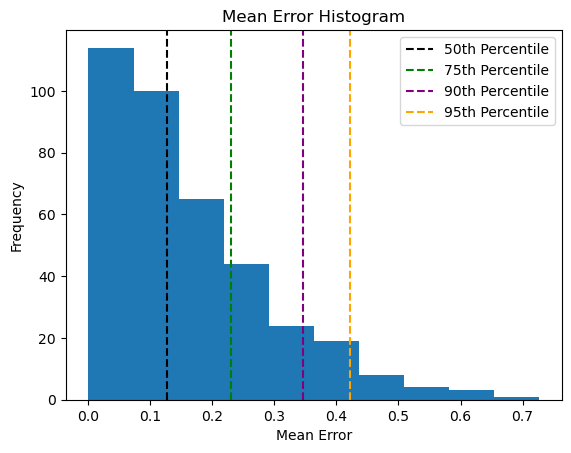

In [6]:
p = [50, 75, 90, 95]
percentiles = np.percentile(abs(prediction_df['Differences']), p)

plt.hist(abs(prediction_df['Differences']))
plt.xlabel('Mean Error')
plt.ylabel('Frequency')
plt.title('Mean Error Histogram')
plt.axvline(percentiles[0], ls='--', color='k', label='50th Percentile')
plt.axvline(percentiles[1], ls='--', color='g', label='75th Percentile')
plt.axvline(percentiles[2], ls='--', color='purple', label='90th Percentile')
plt.axvline(percentiles[3], ls='--', color='orange', label='95th Percentile')
plt.legend()

Overall, I'm pretty happy with these results. 95% of the time we are within <0.4 of the pre-game expected goals.

**Let's have a look at the bottom 10% of models**

In [22]:
prediction_df[abs(prediction_df['Differences']) > 0.5]

,Team,Opponent,Location,PredictedXG,Predictions,Differences
2436,Newcastle,Wolves,Home,2.507966,1.963347,-0.544619
2440,Arsenal,Tottenham,Home,2.440928,1.933919,-0.507009
2718,Brentford,Man United,Home,1.894330,1.376414,-0.517916
2734,Man City,Southampton,Away,2.886654,2.315383,-0.571271
2748,Aston Villa,Tottenham,Home,2.601941,1.972476,-0.629465
2773,Newcastle,Everton,Home,2.421792,1.873838,-0.547954
2782,Aston Villa,Man United,Away,1.933472,1.390935,-0.542536
2786,Brighton,Tottenham,Away,2.286072,1.684129,-0.601943


I can't see any obvious pattern in this data.

#### **Feature Importance**

In [24]:
importances = rf.feature_importances_

pd.DataFrame({'feature': train[predictors].columns,'importance': importances}).sort_values('importance', ascending=False).head(15)

,feature,importance
9,attack_strength,0.540145
10,defence_strength,0.268588
17,location_code,0.073706
7,opp_def_sot_conceded,0.016914
6,opp_def_shots_conceded,0.015640
1,att_goals,0.013472
5,opp_def_goals_conceded,0.009755
3,att_sot,0.009373
2,att_shots,0.008408
4,att_corners,0.005676


This looks expected?

## **5.4 Initial Model Optimisation**

Two key hyperparameters in the model are the lengths of the rolling windows used to construct features: stats_window and betting_window. These control how much historical information is used when summarising team performance and market-implied strength, respectively.

The stats_window parameter governs the rolling averages of match statistics such as shots, goals, and corners. Because these features are computed strictly within a season and require a minimum number of past matches, increasing stats_window reduces the number of usable observations, particularly early in each season. As a result, stats_window cannot be made arbitrarily large without significantly shrinking the training dataset. This introduces a trade-off between feature stability and data availability, and motivates placing a lower bound on acceptable window sizes during optimisation.

In contrast, the betting_window parameter controls the rolling estimation of attack and defence strength derived from market-implied expected goals. These features are allowed to carry information across seasons, reflecting the belief that market assessments of team quality evolve more smoothly and are more transferable between seasons than raw match statistics. While the window is not restricted to a single season, it is still constrained to use only past matches and does not extend beyond the current season boundary.

To identify an appropriate balance between responsiveness and stability, both window lengths are jointly optimised using a grid-based search, subject to the above constraints. This allows the model to select window sizes that maximise predictive performance while preserving a sufficiently large and representative training sample.

In [6]:
predictors = ['Time', 'att_goals', 'att_shots', 'att_sot', 'att_corners', 'opp_def_goals_conceded', 'opp_def_shots_conceded', 
              'opp_def_sot_conceded', 'opp_def_corners_conceded', 'attack_strength', 'defence_strength', 'agg_for', 'opp_agg_for', 
              'TeamPromoted', 'TeamInEurope', 'OppPromoted', 'OppInEurope', 'location_code', 'opp_code', 'team_code', 'season_code', 
              'weekday_code']

optimised_model = pd.DataFrame(columns=['stats_window', 'betting_window', 'MAE', 'max_AE'])

stats_windows = np.arange(3, 11, 1)
betting_windows = np.arange(6, 31, 2)

for stats_window in stats_windows:
    for betting_window in betting_windows:
        data = prepare_data(stats_window, betting_window)

        train = data[data['Date'] < pd.to_datetime('2025-01-01')]
        test = data[(data['Date'] >= pd.to_datetime('2025-01-01')) & (data['Date'] < pd.to_datetime('2025-06-01'))]

        

# **Attempting Model**

## Building dataset and trying simple prediction